<a id = 'intro'></a>
# Introduction

League of Legends is an online-multiplayer video game consisting of two, five player teams. The objective of the game is to destroy the enemy team's nexus. To gain an advantage, teams collect gold through kills and objectives. The game is highly competitive and requires teamwork.

In this analysis, we will look at data consisting of the first 10 minutes of Diamond ranked games. We will use Sklearn to cluster the data using all the available clustering algorithms. The purpose of this project is to familiarize myself with the Sklean clustering API and to show others how simple it is to use it.

<a id = 'top'></a>
# Table of Contents

* [Introduction](#intro)

* [Data Cleaning](#cleaning)
    * [Remove Repeated Columns](#repeated_columns)
    * [Remove Outliers](#remove_outliers)
    * [Rescaling Features](#rescaling)
    * [Remove Null Values](#null)
   
* [Clustering](#clusters)
    * [K-Means](#kmeans)
    * [Affinity Propagation](#affinity)
    * [Mean Shift](#mean_shift)
    * [Spectral Clustering](#spectral)
    * [Agglomerative Clustering](#agglomerative)
        * [Ward](#ward)
        * [Complete](#complete)
        * [Average](#average)
        * [Single](#single)
    * [DSCAN](#dbscan)
    * [OPTICS](#optics)
    * [Birch](#birch)

* [Clustering Discussion](#discussion)
* [Team Advantage Column](#advantage)

<a id = 'cleaning'></a>
# Data Cleaning

We begin our analysis with reading the csv file and inspecting its columns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
sns.set_style('darkgrid')

RED = '#D10000'
BLUE = '#0082FF'

In [2]:
data = pd.read_csv('../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv')
data.head()

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  

[5 rows x 40 columns]

In [3]:
# get the column list
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

We can see that this dataset consists of 40 columns. Some of the columns are named differently, but contain the same information. For example, the "blueKills" column should be the same as the "redDeaths" column. Afterall, if a blue team gets a kill, then a red team member must have been killed.

<a id = 'repeated_columns'></a>
## Remove Repeated Columns

Next we can see a list of potential repeated columns:
* blueFirstBlood is the opposite of redFirstBlood. If blue team gets first blood, the column is assigned a 1 and 0 for the red team. The opposite is true for red team.
* blueKills is redDeaths
* blueDeaths is redKills
* blueExperienceDiff is the negative of redExperienceDiff
* blueGoldDiff is the negative redGoldDiff

Below we verify that these relationships are true.

In [4]:
# first blood
all(data['blueFirstBlood'] == data['redFirstBlood'].apply(lambda x: 0 if x == 1 else 1))

True

In [5]:
# blue kills is red deaths
all(data['blueKills'] == data['redDeaths'])

True

In [6]:
# blue deaths is red kills
all(data['blueDeaths'] == data['redKills'])

True

In [7]:
# blue experience difference is the negative of red experience difference
all(data['blueExperienceDiff'] == data['redExperienceDiff'].apply(lambda x: -1*x))

True

In [8]:
# blue gold difference is the negative of red gold difference
all(data['blueGoldDiff'] == data['redGoldDiff'].apply(lambda x: -1*x))

True

The decrease the amount of features, we will drop the repeated columns that contain red team information. We are keeping the blue team columns just because of the "blueWins" feature. We will also drop the "gameId", since it does not contribute to the characteristics of the games.

In [9]:
data.drop(['redFirstBlood','redDeaths','redKills','redExperienceDiff','redGoldDiff', 'gameId'],
          axis = 1, inplace = True)

Now we gather the blue and red team columns to get a rough idea of their distributions.

In [10]:
blue_team = [column for column in data.columns if 'blue' in column]
red_team = [column for column in data.columns if 'red' in column]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


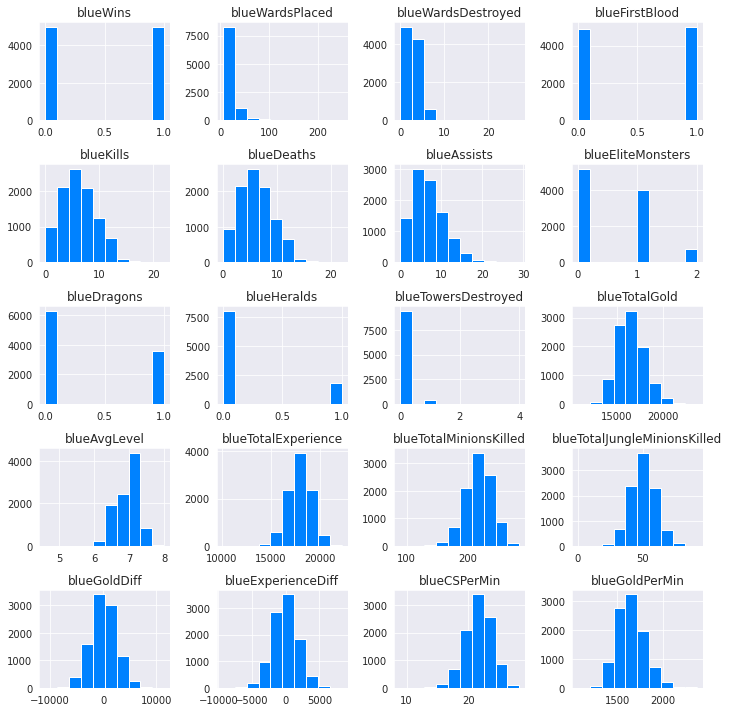

In [11]:
data[blue_team].hist(color = BLUE,
                     figsize = (10,10))
plt.tight_layout()
plt.show()

From the histogram above, we can see that the columns that are approximately normal are blueKills, blueDeaths, blueAssists, blueTotalGold, blueAvgLevel, blueTotalExperience, blueTotalMinionsKilled, blueTotalJungleMinionsKilled, blueGoldDiff, blueExperienceDiff, blueCSPerMin and blueGoldPerMin.

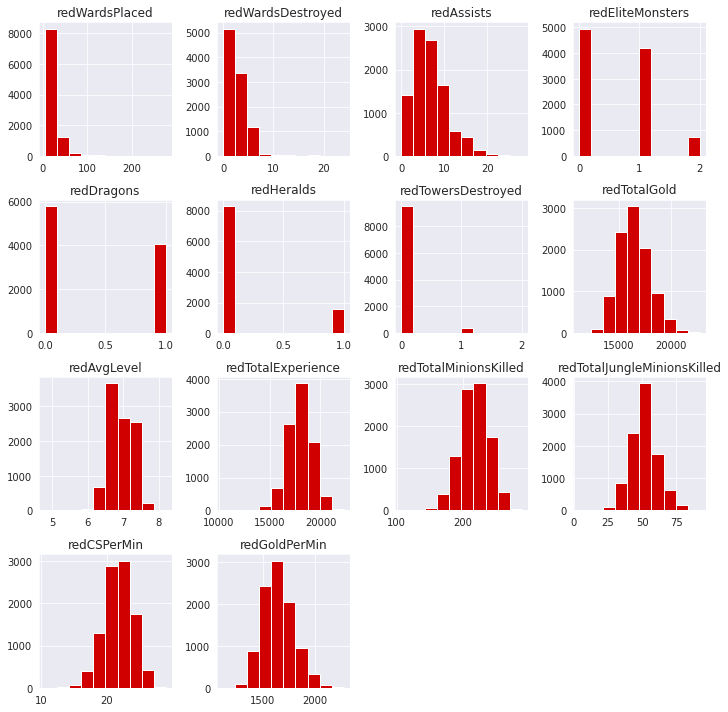

In [12]:
data[red_team].hist(color = RED,
                    figsize = (10,10))

plt.tight_layout()
plt.show()

From the histogram above, we can see similar normal distributions in the red team columns: redAssists, redTotalGold, redAvgLevel, redTotalExperience, redTotalMinionsKilled, redTotalJungleMinionsKilled, redCSPerMin, and redGoldPerMin.

[back to top](#top)

<a id = 'remove_outliers'></a>
## Remove Outliers

Next, we will visualize the features using boxplots and remove any statistical outliers. For this analysis, we will keep any data points that are within 3 standard deviations from the mean.

We start with the blue team.

In [13]:
# collect the columns that are "normally distributed".
normal_columns = ['blueWardsPlaced','blueWardsDestroyed','blueKills','blueDeaths',
                  'blueAssists','blueTotalGold','blueAvgLevel','blueTotalExperience',
                  'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
                  'blueGoldDiff','blueExperienceDiff','blueCSPerMin','blueGoldPerMin',
                  'redWardsPlaced','redAssists','redTotalGold','redAvgLevel','redTotalExperience',
                  'redTotalMinionsKilled','redTotalJungleMinionsKilled',
                  'redCSPerMin','redGoldPerMin']

# we need to group the columns with similar range so that the boxplots look interpretable
blue_normal = [column for column in normal_columns if 'blue' in column]
data[blue_normal].describe().T

count          mean          std      min  \
blueWardsPlaced               9879.0     22.288288    18.019177      5.0   
blueWardsDestroyed            9879.0      2.824881     2.174998      0.0   
blueKills                     9879.0      6.183925     3.011028      0.0   
blueDeaths                    9879.0      6.137666     2.933818      0.0   
blueAssists                   9879.0      6.645106     4.064520      0.0   
blueTotalGold                 9879.0  16503.455512  1535.446636  10730.0   
blueAvgLevel                  9879.0      6.916004     0.305146      4.6   
blueTotalExperience           9879.0  17928.110133  1200.523764  10098.0   
blueTotalMinionsKilled        9879.0    216.699565    21.858437     90.0   
blueTotalJungleMinionsKilled  9879.0     50.509667     9.898282      0.0   
blueGoldDiff                  9879.0     14.414111  2453.349179 -10830.0   
blueExperienceDiff            9879.0    -33.620306  1920.370438  -9333.0   
blueCSPerMin                  9879.0     21.669956     2.185844      9.0   
blueGoldPerMin                9879.0   1650.345551   153.544664   1073.0   

                                   25%      50%      75%      max  
blueWardsPlaced                  14.00     16.0     20.0    250.0  
blueWardsDestroyed                1.00      3.0      4.0     27.0  
blueKills                         4.00      6.0      8.0     22.0  
blueDeaths                        4.00      6.0      8.0     22.0  
blueAssists                       4.00      6.0      9.0     29.0  
blueTotalGold                 15415.50  16398.0  17459.0  23701.0  
blueAvgLevel                      6.80      7.0      7.2      8.0  
blueTotalExperience           17168.00  17951.0  18724.0  22224.0  
blueTotalMinionsKilled          202.00    218.0    232.0    283.0  
blueTotalJungleMinionsKilled     44.00     50.0     56.0     92.0  
blueGoldDiff                  -1585.50     14.0   1596.0  11467.0  
blueExperienceDiff            -1290.50    -28.0   1212.0   8348.0  
blueCSPerMin                     20.20     21.8     23.2     28.3  
blueGoldPerMin                 1541.55   1639.8   1745.9   2370.1

In [14]:
# group the blue columns by relative size
small_blue = ['blueWardsPlaced','blueWardsDestroyed','blueKills',
              'blueDeaths','blueAssists','blueAvgLevel','blueTotalMinionsKilled',
              'blueTotalJungleMinionsKilled','blueCSPerMin']
large_blue = [column for column in blue_normal if column not in small_blue]

In [15]:
def plot_boxplot(data, subset, color, title):
    plt.figure(figsize = (11,9))
    g = sns.boxplot(data = data[subset], color = color)
    g.set_title(title)
    plt.xticks(rotation = 30)
    plt.show()

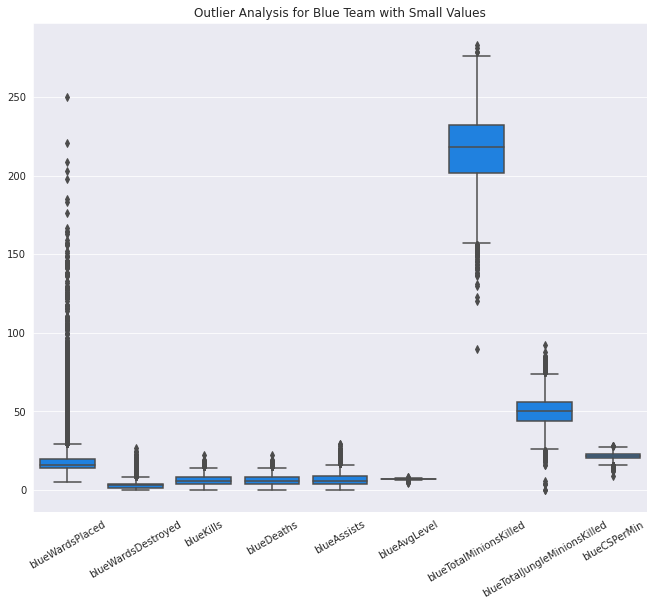

In [16]:
# now we visualize
plot_boxplot(data, small_blue, BLUE, 'Outlier Analysis for Blue Team with Small Values')

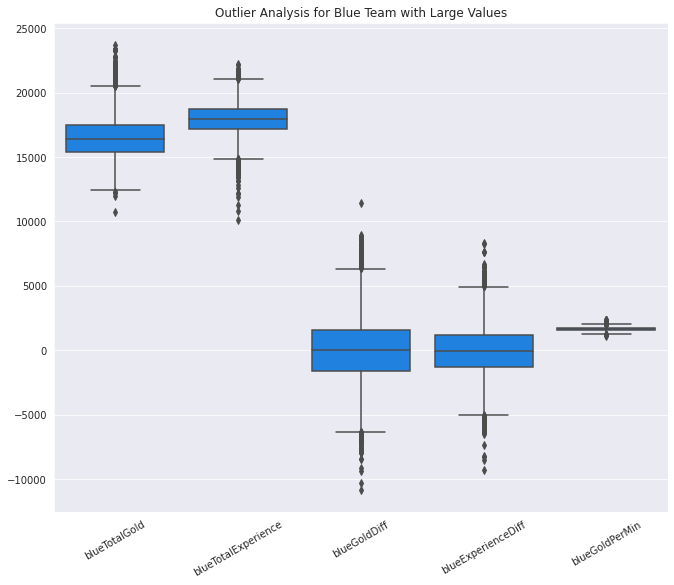

In [17]:
plot_boxplot(data, large_blue, BLUE, 'Outlier Analysis for Blue Team with Large Values')

In both of the boxplots above, we can see many outliers. As mentioned before, we will remove data points that are 3 standard deviations away from the mean.

In [18]:
def remove_outliers(data):
    """
    Remove the outlier if it is 3 standard deviations away from the mean
    """
    for column in data.columns:
        column_mean = data[column].mean()
        column_std = data[column].std()
        threshold = column_std*3 # three standard deviations
        lower, upper = column_mean - threshold, column_mean + threshold
        data = data[(data[column] >= lower) & (data[column] <= upper)]
    return data

In [19]:
# remove the outliers for the blue team
data_no_outliers = remove_outliers(data)

Let's visualize the same features after the outliers have been removed.

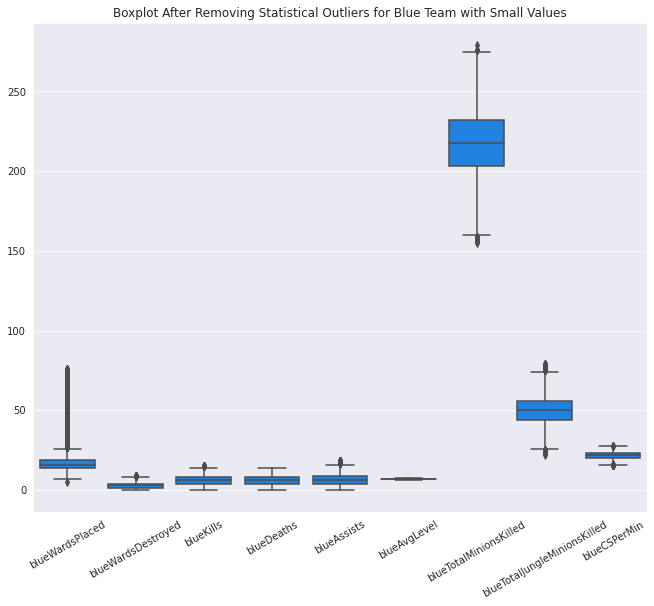

In [20]:
# now we visualize after removing outliers
plot_boxplot(data_no_outliers, small_blue, BLUE, 'Boxplot After Removing Statistical Outliers for Blue Team with Small Values')

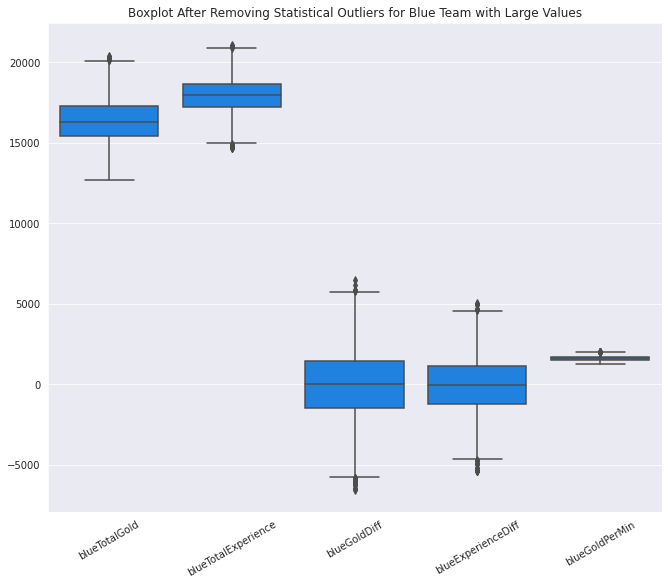

In [21]:
plot_boxplot(data_no_outliers, large_blue, BLUE, 'Boxplot After Removing Statistical Outliers for Blue Team with Large Values')

Let's do the same thing to the red team.

In [22]:
red_normal = [column for column in normal_columns if 'red' in column]
data[red_normal].describe().T

count          mean          std      min  \
redWardsPlaced               9879.0     22.367952    18.457427      6.0   
redAssists                   9879.0      6.662112     4.060612      0.0   
redTotalGold                 9879.0  16489.041401  1490.888406  11212.0   
redAvgLevel                  9879.0      6.925316     0.305311      4.8   
redTotalExperience           9879.0  17961.730438  1198.583912  10465.0   
redTotalMinionsKilled        9879.0    217.349226    21.911668    107.0   
redTotalJungleMinionsKilled  9879.0     51.313088    10.027885      4.0   
redCSPerMin                  9879.0     21.734923     2.191167     10.7   
redGoldPerMin                9879.0   1648.904140   149.088841   1121.2   

                                  25%      50%       75%      max  
redWardsPlaced                  14.00     16.0     20.00    276.0  
redAssists                       4.00      6.0      9.00     28.0  
redTotalGold                 15427.50  16378.0  17418.50  22732.0  
redAvgLevel                      6.80      7.0      7.20      8.2  
redTotalExperience           17209.50  17974.0  18764.50  22269.0  
redTotalMinionsKilled          203.00    218.0    233.00    289.0  
redTotalJungleMinionsKilled     44.00     51.0     57.00     92.0  
redCSPerMin                     20.30     21.8     23.30     28.9  
redGoldPerMin                 1542.75   1637.8   1741.85   2273.2

In [23]:
small_red = ['redWardsPlaced','redAssists','redAvgLevel',
             'redTotalMinionsKilled','redTotalJungleMinionsKilled', 
             'redCSPerMin']
large_red = [column for column in red_normal if column not in small_red]

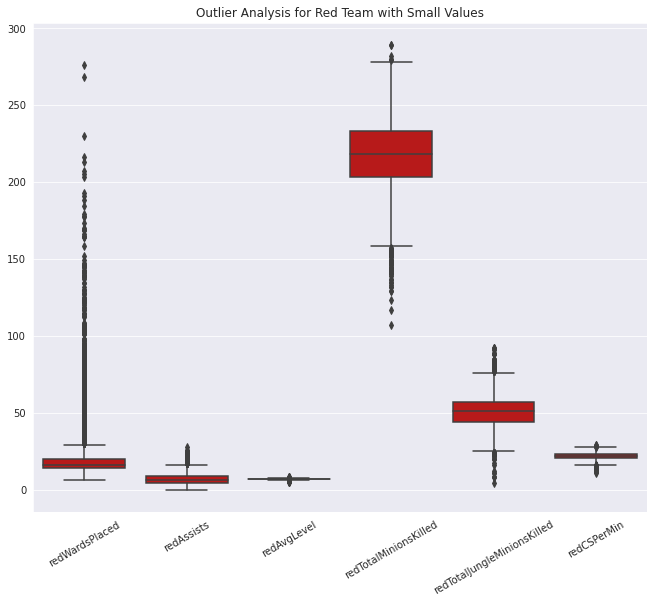

In [24]:
# visualize small red
plot_boxplot(data, small_red, RED, 'Outlier Analysis for Red Team with Small Values')

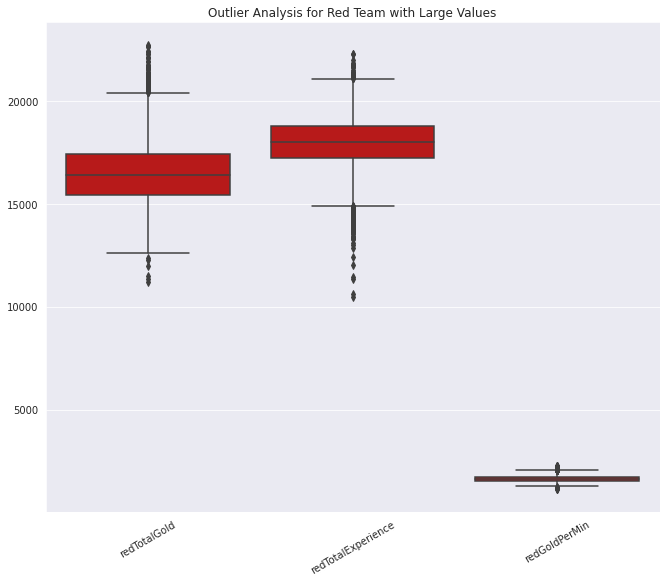

In [25]:
plot_boxplot(data, large_red, RED, 'Outlier Analysis for Red Team with Large Values')

Now we remove the outliers.

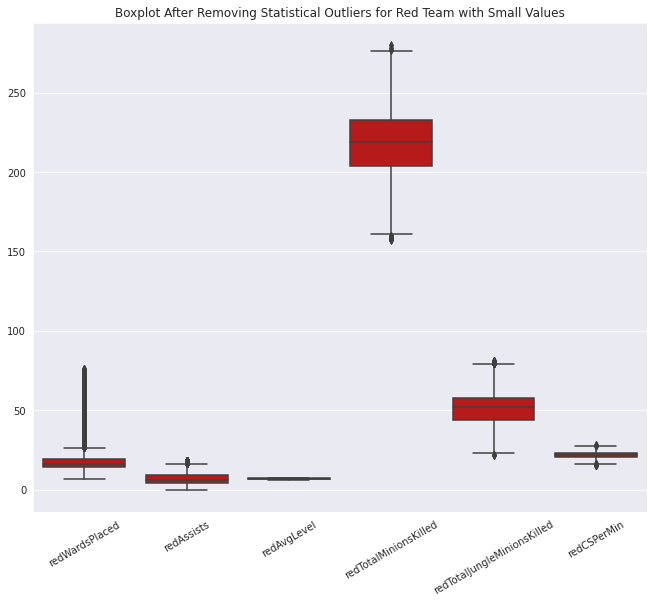

In [26]:
plot_boxplot(data_no_outliers, small_red, RED, 'Boxplot After Removing Statistical Outliers for Red Team with Small Values')

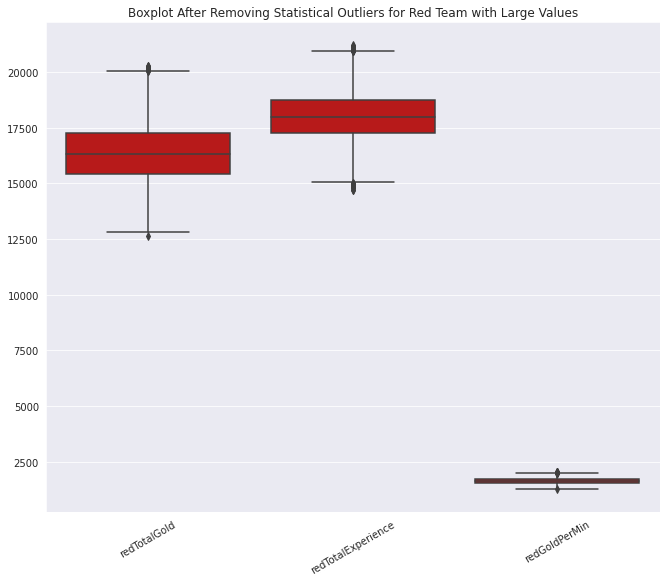

In [27]:
plot_boxplot(data_no_outliers, large_red, RED, 'Boxplot After Removing Statistical Outliers for Red Team with Large Values')

[back to top](#top)

<a id = 'rescaling'></a>
## Rescaling Features

We will use Sklearn's StandardScaler to rescale the data.

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_tr = pd.DataFrame(scaler.fit_transform(data_no_outliers.drop('blueWins', axis = 1)), 
                       columns = data_no_outliers.drop('blueWins', axis = 1).columns)

# add the bluewins column back in
data_tr['blueWins'] = data_no_outliers['blueWins']

In [29]:
# verify that the columns are scaled
data_tr.describe().T

count          mean       std       min  \
blueWardsPlaced               7888.0 -3.062684e-17  1.000063 -1.437571   
blueWardsDestroyed            7888.0  9.773566e-17  1.000063 -1.598981   
blueFirstBlood                7888.0  4.458908e-17  1.000063 -1.006104   
blueKills                     7888.0  8.017026e-17  1.000063 -2.171236   
blueDeaths                    7888.0 -9.638447e-17  1.000063 -2.192745   
blueAssists                   7888.0 -1.216066e-16  1.000063 -1.732004   
blueEliteMonsters             7888.0 -8.017026e-17  1.000063 -0.861644   
blueDragons                   7888.0  1.026900e-16  1.000063 -0.751511   
blueHeralds                   7888.0  5.404737e-17  1.000063 -0.452781   
blueTowersDestroyed           7888.0  0.000000e+00  0.000000  0.000000   
blueTotalGold                 7888.0  4.729145e-16  1.000063 -2.774402   
blueAvgLevel                  7888.0  5.490312e-16  1.000063 -2.613556   
blueTotalExperience           7888.0 -4.909303e-16  1.000063 -3.025682   
blueTotalMinionsKilled        7888.0 -2.841991e-16  1.000063 -3.020578   
blueTotalJungleMinionsKilled  7888.0 -1.400728e-16  1.000063 -3.034629   
blueGoldDiff                  7888.0  0.000000e+00  1.000063 -3.138948   
blueExperienceDiff            7888.0  1.441263e-17  1.000063 -3.175388   
blueCSPerMin                  7888.0  2.130817e-15  1.000063 -3.020578   
blueGoldPerMin                7888.0  8.089089e-16  1.000063 -2.774402   
redWardsPlaced                7888.0 -6.305526e-17  1.000063 -1.222892   
redWardsDestroyed             7888.0 -9.683487e-17  1.000063 -1.585825   
redAssists                    7888.0 -9.007895e-19  1.000063 -1.716456   
redEliteMonsters              7888.0 -9.097974e-17  1.000063 -0.903320   
redDragons                    7888.0 -1.420995e-16  1.000063 -0.838851   
redHeralds                    7888.0 -5.404737e-18  1.000063 -0.414808   
redTowersDestroyed            7888.0  0.000000e+00  0.000000  0.000000   
redTotalGold                  7888.0  2.179911e-16  1.000063 -2.861513   
redAvgLevel                   7888.0  2.008761e-15  1.000063 -2.661436   
redTotalExperience            7888.0 -9.746542e-16  1.000063 -3.029994   
redTotalMinionsKilled         7888.0  4.197679e-16  1.000063 -2.977518   
redTotalJungleMinionsKilled   7888.0 -3.233834e-16  1.000063 -3.034480   
redCSPerMin                   7888.0 -1.307946e-15  1.000063 -2.977518   
redGoldPerMin                 7888.0  1.613314e-15  1.000063 -2.861513   
blueWins                      6330.0  4.992101e-01  0.500039  0.000000   

                                   25%       50%       75%       max  
blueWardsPlaced              -0.557990 -0.362527 -0.069334  5.501347  
blueWardsDestroyed           -1.006804  0.177548  0.769724  3.730604  
blueFirstBlood               -1.006104  0.993933  0.993933  0.993933  
blueKills                    -0.724143 -0.000596  0.722950  3.255364  
blueDeaths                   -0.721120  0.014692  0.750504  2.957941  
blueAssists                  -0.653854 -0.114779  0.693834  3.119672  
blueEliteMonsters            -0.861644 -0.861644  0.760855  2.383353  
blueDragons                  -0.751511 -0.751511  1.330652  1.330652  
blueHeralds                  -0.452781 -0.452781 -0.452781  2.208573  
blueTowersDestroyed           0.000000  0.000000  0.000000  0.000000  
blueTotalGold                -0.725331 -0.038554  0.680122  3.010283  
blueAvgLevel                 -0.436145  0.289659  1.015463  2.467071  
blueTotalExperience          -0.680359  0.006837  0.691957  2.902794  
blueTotalMinionsKilled       -0.699413  0.025951  0.702957  2.975763  
blueTotalJungleMinionsKilled -0.705659 -0.070485  0.564688  2.999520  
blueGoldDiff                 -0.690854  0.000268  0.685268  3.127481  
blueExperienceDiff           -0.686539  0.001747  0.692995  3.015921  
blueCSPerMin                 -0.699413  0.025951  0.702957  2.975763  
blueGoldPerMin               -0.725331 -0.038554  0.680122  3.010283  
redWardsPlaced      

[back to top](#top)

<a id = 'null'></a>
## Remove Null-Values

We can see above that the blueWins column has 6330 non-null values compared to the other features which have 7888 non-null values. Some of the values were dropped. We will remove the columns that contain null values.

In [30]:
data_tr.dropna(inplace = True, axis = 0)
data_tr.describe().T

count      mean       std       min       25%  \
blueWardsPlaced               6330.0  0.013375  1.019269 -1.437571 -0.557990   
blueWardsDestroyed            6330.0 -0.005718  1.000735 -1.598981 -1.006804   
blueFirstBlood                6330.0 -0.004821  1.000097 -1.006104 -1.006104   
blueKills                     6330.0 -0.000025  0.993264 -2.171236 -0.724143   
blueDeaths                    6330.0  0.009229  1.000043 -2.192745 -0.721120   
blueAssists                   6330.0 -0.004792  0.996005 -1.732004 -0.653854   
blueEliteMonsters             6330.0 -0.000412  1.000066 -0.861644 -0.861644   
blueDragons                   6330.0 -0.001866  0.999537 -0.751511 -0.751511   
blueHeralds                   6330.0  0.001709  1.001577 -0.452781 -0.452781   
blueTowersDestroyed           6330.0  0.000000  0.000000  0.000000  0.000000   
blueTotalGold                 6330.0 -0.000716  0.998191 -2.774402 -0.732649   
blueAvgLevel                  6330.0  0.000943  0.999672 -2.613556 -0.436145   
blueTotalExperience           6330.0  0.002031  1.000250 -3.021991 -0.677360   
blueTotalMinionsKilled        6330.0 -0.005066  0.996696 -2.972220 -0.699413   
blueTotalJungleMinionsKilled  6330.0  0.002046  1.001775 -3.034629 -0.705659   
blueGoldDiff                  6330.0 -0.007502  1.002592 -3.138948 -0.708498   
blueExperienceDiff            6330.0 -0.003017  1.002666 -3.175388 -0.691724   
blueCSPerMin                  6330.0 -0.005066  0.996696 -2.972220 -0.699413   
blueGoldPerMin                6330.0 -0.000716  0.998191 -2.774402 -0.732649   
redWardsPlaced                6330.0  0.003062  1.001141 -1.222892 -0.557107   
redWardsDestroyed             6330.0  0.008722  1.002269 -1.585825 -0.978150   
redAssists                    6330.0  0.004305  0.995816 -1.716456 -0.649121   
redEliteMonsters              6330.0 -0.001217  0.995765 -0.903320 -0.903320   
redDragons                    6330.0  0.003050  1.000613 -0.838851 -0.838851   
redHeralds                    6330.0 -0.006373  0.993678 -0.414808 -0.414808   
redTowersDestroyed            6330.0  0.000000  0.000000  0.000000  0.000000   
redTotalGold                  6330.0  0.011182  0.999925 -2.861513 -0.713715   
redAvgLevel                   6330.0  0.004948  1.003435 -2.661436 -0.479850   
redTotalExperience            6330.0  0.006747  1.002510 -3.029994 -0.663258   
redTotalMinionsKilled         6330.0  0.002261  1.002445 -2.977518 -0.696251   
redTotalJungleMinionsKilled   6330.0  0.003019  1.002667 -3.034480 -0.769833   
redCSPerMin                   6330.0  0.002261  1.002445 -2.977518 -0.696251   
redGoldPerMin                 6330.0  0.011182  0.999925 -2.861513 -0.713715   
blueWins                      6330.0  0.499210  0.500039  0.000000  0.000000   

                                   50%       75%       max  
blueWardsPlaced              -0.362527 -0.069334  5.501347  
blueWardsDestroyed           -0.414628  0.769724  3.730604  
blueFirstBlood                0.993933  0.993933  0.993933  
blueKills                    -0.000596  0.722950  3.255364  
blueDeaths                    0.014692  0.750504  2.957941  
blueAssists                  -0.114779  0.693834  3.119672  
blueEliteMonsters            -0.861644  0.760855  2.383353  
blueDragons                  -0.751511  1.330652  1.330652  
blueHeralds                  -0.452781 -0.452781  2.208573  
blueTowersDestroyed           0.000000  0.000000  0.000000  
blueTotalGold                -0.034051  0.679559  3.010283  
blueAvgLevel                  0.289659  1.015463  2.467071  
blueTotalExperience           0.008682  0.696340  2.902794  
blueTotalMinionsKilled        0.025951  0.702957  2.975763  
blueTotalJungleMinionsKilled -0.070485  0.564688  2.999520  
blueGoldDiff                 -0.003813  0.685388  3.127481  
blueExperienceDiff           -0.007438  0.692995  2.983922  
blueCSPerMin                  0.025951  0.702957  2.975763  
blueGoldPerMin               -0.034051  0.679559  3.010283  
redWardsPl

[back to top](#top)

<a id = 'clusters'></a>
# Clustering

Sklearn's API allows us to build many unsupervised learning models easily. For this analysis, we will use all of the unsupervised learning algorithms that sklearn supports. This includes: K-Means, Affinity Propagation, Mean Shift, Spectral Clustering, Agglomerative Clustering, DBSCAN, OPTICS, BIRCH, and Gaussian Mixtures. A summary of how each clustering algorithm works is found in the documentation [here](https://scikit-learn.org/stable/modules/clustering.html).


I would like to see how long it takes to run these clustering algorithms. Below we define a function that will time the algortihms for us.

For each clustering algorithm, we will plot the Blue Team's total gold earned versus the Red Team's.

In [31]:
def FormatIt(delta):
    """
    Input is a datetime object. We will format it based on how many
    seconds it contains
    """
    message = 'Time elapsed is '
    # format the seconds
    if (delta.seconds == 0) & (delta.microseconds < 1000000):
        print(message + '{} microseconds'.format(delta.microseconds))
  
    elif delta.seconds < 60:
        print(message + '{} seconds'.format(delta.seconds))
    
    elif delta.seconds < 3600:
        minutes = int(delta.seconds / 60)
        seconds = delta.seconds % 60
        print(message + '{} minutes {} seconds'.format(minutes, seconds))
      
    else:
        hours = int(delta.seconds / 3600)
        minutes = int(delta.seconds / 60)
        seconds = delta.seconds % 60
        print(message + '{} hours {} minutes {} seconds'.format(hours, minutes, seconds))

class TimeIt():
    """
    So we can find out how long the algorithms take to run
    """
    def __init__(self):
        """
        Get the current time
        """
        self.start = datetime.now()
    
    def stop(self):
        self.end = datetime.now()
        self.delta = self.end - self.start
        FormatIt(self.delta)
        
class Clusters():
    """
    So that we can plot the clusters of each algorithm easily
    """
    def __init__(self, cluster_name, cluster_list, data):
        self.cluster_name = cluster_name
        self.cluster_list = cluster_list
        self.cluster_labels = [model.labels_ for model in self.cluster_list]
        self.data = data.copy()
                
    def plot(self):
        fig, axs = plt.subplots(2,2, figsize = (11,9))
        
        # add the first cluster label to the df
        self.data.insert(0, 'Clusters', self.cluster_labels[0])
        
        # first scatter plot
        g = sns.scatterplot(data = self.data,
                            x = 'blueTotalGold',
                            y = 'redTotalGold',
                            hue = 'Clusters',
                            alpha = 0.5,
                            edgecolor = 'k',
                            palette = 'viridis',
                            ax = axs[0][0])
        
        # replace the cluster labels for the next model
        self.data['Clusters'] = self.cluster_labels[1]
        
        # second scatter plot
        g = sns.scatterplot(data = self.data,
                            x = 'blueTotalGold',
                            y = 'redTotalGold',
                            hue = 'Clusters',
                            alpha = 0.5,
                            edgecolor = 'k',
                            palette = 'viridis',
                            ax = axs[0][1])
        
        # replace the cluster labels for the next model
        self.data['Clusters'] = self.cluster_labels[2]
        
        # third scatter plot
        g = sns.scatterplot(data = self.data,
                            x = 'blueTotalGold',
                            y = 'redTotalGold',
                            hue = 'Clusters',
                            alpha = 0.5,
                            edgecolor = 'k',
                            palette = 'viridis',
                            ax = axs[1][0])
        
        # replace the cluster labels for the next model
        self.data['Clusters'] = self.cluster_labels[3]
        
        # fourth scatter plot
        g = sns.scatterplot(data = self.data,
                            x = 'blueTotalGold',
                            y = 'redTotalGold',
                            hue = 'Clusters',
                            alpha = 0.5,
                            edgecolor = 'k',
                            palette = 'viridis',
                            ax = axs[1][1])
        
        title = 'Scatterplots for {}'.format(self.cluster_name)
        fig.suptitle(title, fontsize = 16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.88)
        plt.show()

<a id = 'kmeans'></a>
## K-Means Clustering

According to the Sklearn documentation, "The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields."

We will run 4 different K-Means Clustering algorithms using 2,3,4, and 5 clusters.

In [32]:
# make a copy so we don't change the original df
data_copy = data_tr.copy()
data_not_scaled = pd.DataFrame(scaler.inverse_transform(data_tr.drop('blueWins', axis = 1)),
                               columns = data_tr.drop('blueWins', axis = 1).columns)
data_not_scaled['blueWins'] = data_tr['blueWins']

In [33]:
from sklearn.cluster import KMeans

timer = TimeIt()
k_means_list = [KMeans(n_clusters = k, random_state = 42).fit(data_copy.values) for k in range(2,6)]
timer.stop()

Time elapsed is 6 seconds


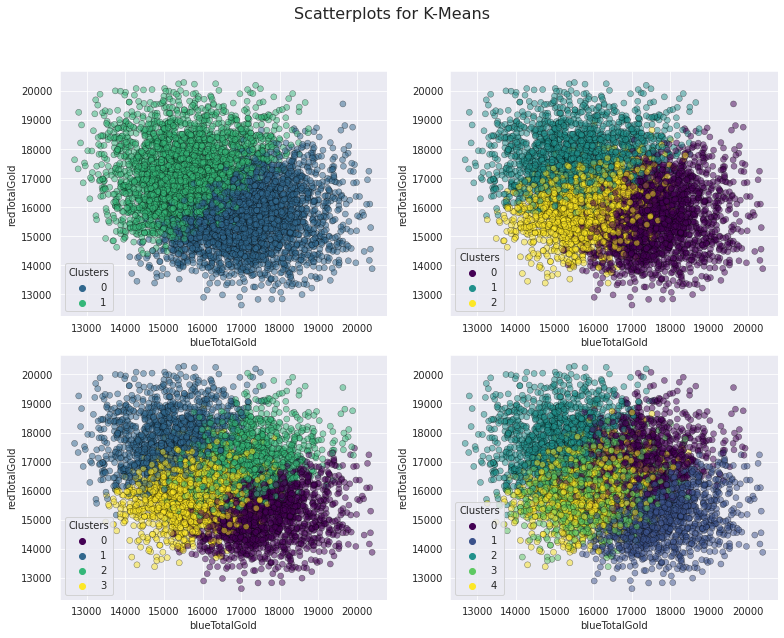

In [34]:
# now we plot it
kmeans_cluster = Clusters('K-Means', k_means_list, data_not_scaled)
kmeans_cluster.plot()

[back to top](#top)

<a id = 'affinity'></a>
## Affinity Propagation

From wikipedia, "affinity propagation is a clustering algorithm based on the concept of 'message passing' between data points. Unlike clustering algorithms such as k-means or k-medoids, affinity propagation does not require the number of clusters to be determined or estimated before running the algorithm. Similar to k-mediods, affinity propagation finds 'exemplars', members of the input set that are representative of clusters."

https://en.wikipedia.org/wiki/Affinity_propagation


We will run 4 different Affinity Propagation algorithms with different values for the damping hyperparameter.

In [35]:
from sklearn.cluster import AffinityPropagation

timer = TimeIt()
AP_list = [AffinityPropagation(damping = 0.5 + i*0.05, random_state = 42).fit(data_copy.values) for i in range(4)]
timer.stop()

Time elapsed is 3 minutes 25 seconds


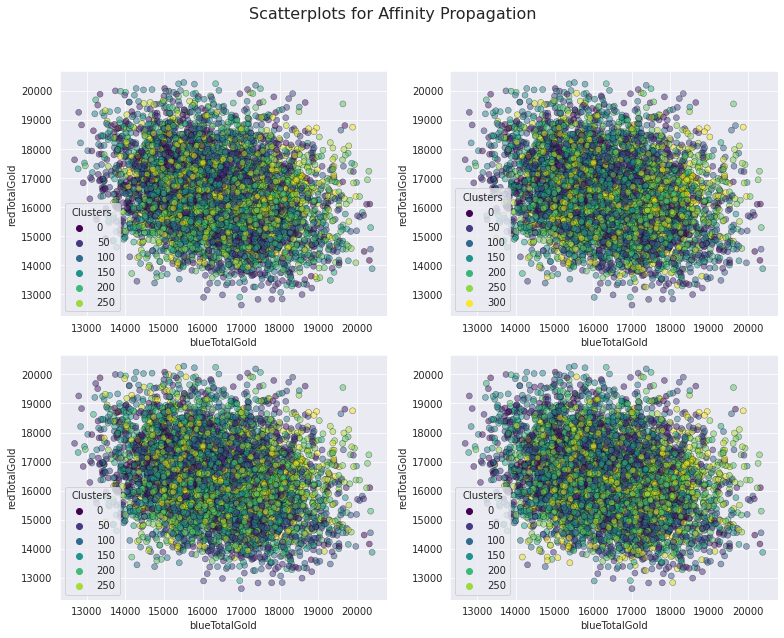

In [36]:
# now we plot
AP_clusters = Clusters('Affinity Propagation', AP_list, data_not_scaled)
AP_clusters.plot()

[back to top](#top)

<a id = 'mean_shift'></a>
## Mean Shift

According to the sklearn documentation, "MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region."

The hyperparameter for mean-shift is the bandwidth. We will run 4 different Mean Shift algorithms with different values for the bandwidth.

In [37]:
from sklearn.cluster import MeanShift

timer = TimeIt()
MS_list = [MeanShift(bandwidth = 1.25*i).fit(data_copy.values) for i in range(1,5)]
timer.stop()

Time elapsed is 8 minutes 2 seconds


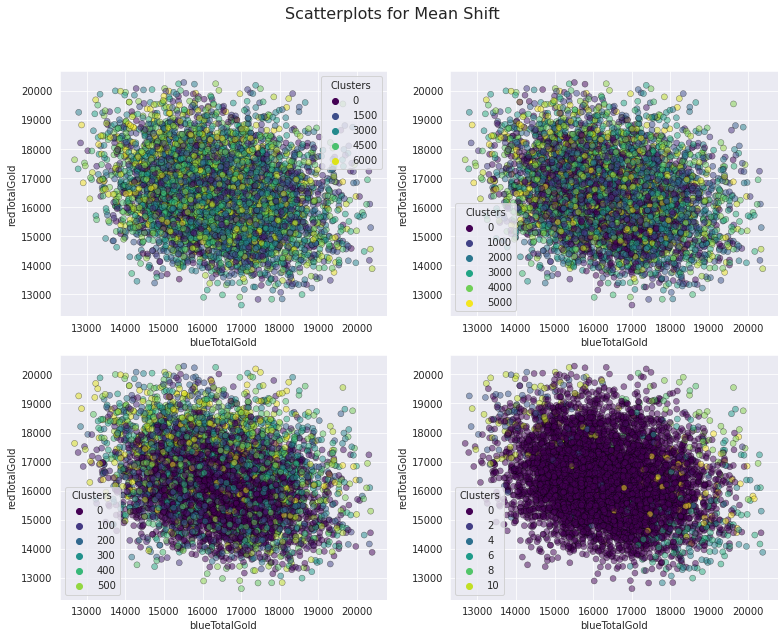

In [38]:
MS_clusters = Clusters('Mean Shift', MS_list, data_not_scaled)
MS_clusters.plot()

[back to top](#top)

<a id = 'spectral'></a>
## Spectral Clustering

According to the sklearn documentation: "Spectral Clustering performs a low-dimensional embedding of the affinity matrix between samples, followed by clustering, e.g., by KMeans, of the components of the eigenvectors in the low dimensional space".

The hypyerparameter for spectral clustering is number of clusters. We will run 4 different Spectral Clustering algorithms with 2,3,4 and 5 for the number of clusters.

In [39]:
from sklearn.cluster import SpectralClustering

timer = TimeIt()
SC_list = [SpectralClustering(random_state = 42, n_clusters = i).fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 8 minutes 48 seconds


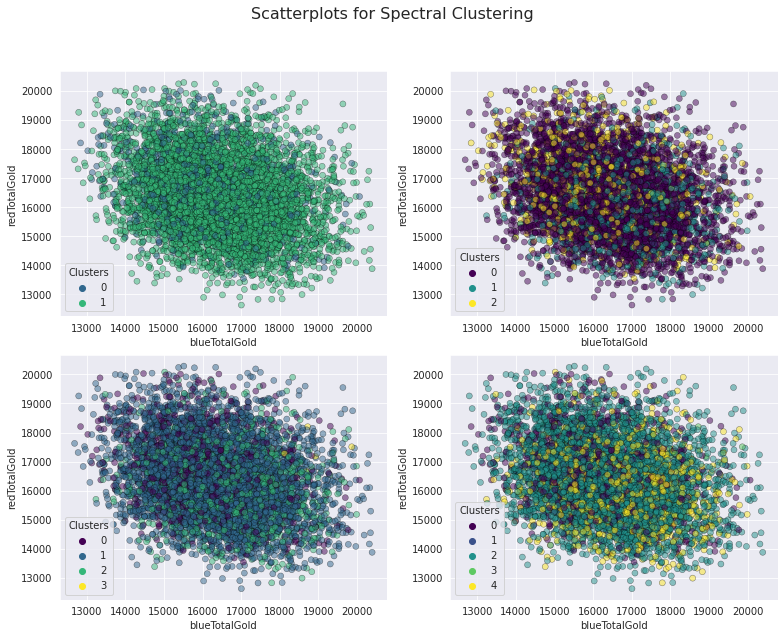

In [40]:
SC_clusters = Clusters('Spectral Clustering', SC_list, data_not_scaled)
SC_clusters.plot()

[back to top](#top)

<a id = 'agglomerative'></a>
## Agglomerative Clustering

According to the sklearn documentation: "Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample."

We will be experimenting with number of clusters and the linkage parameters. The different linkage parameters are: ward, complete, average, and single.

In [41]:
from sklearn.cluster import AgglomerativeClustering

<a id = 'ward'></a>
### Ward Clustering

In [42]:
timer = TimeIt()
Ward_list = [AgglomerativeClustering(n_clusters = i, linkage = 'ward').fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 7 seconds


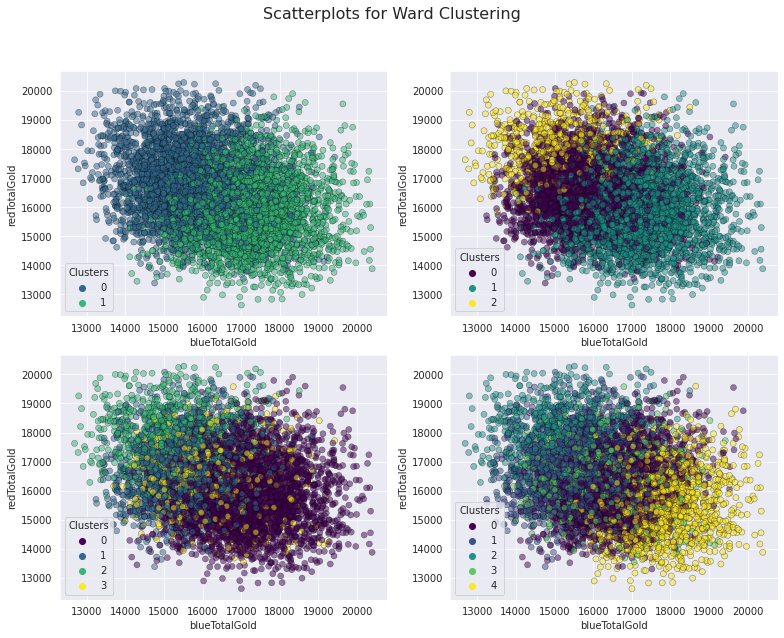

In [43]:
Ward_clusters = Clusters('Ward Clustering', Ward_list, data_not_scaled)
Ward_clusters.plot()

[back to top](#top)

<a id = 'complete'></a>
### Complete Clustering

In [44]:
timer = TimeIt()
Complete_list = [AgglomerativeClustering(n_clusters = i, linkage = 'complete').fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 6 seconds


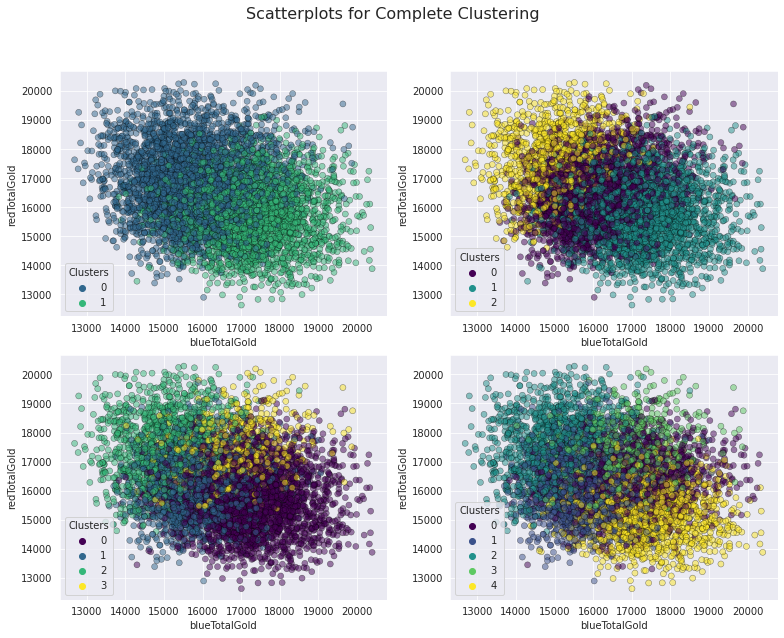

In [45]:
Complete_clusters = Clusters('Complete Clustering', Complete_list, data_not_scaled)
Complete_clusters.plot()

[back to top](#top)

<a id = 'average'></a>
### Average Clustering

In [46]:
timer = TimeIt()
Average_list = [AgglomerativeClustering(n_clusters = i, linkage = 'average').fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 7 seconds


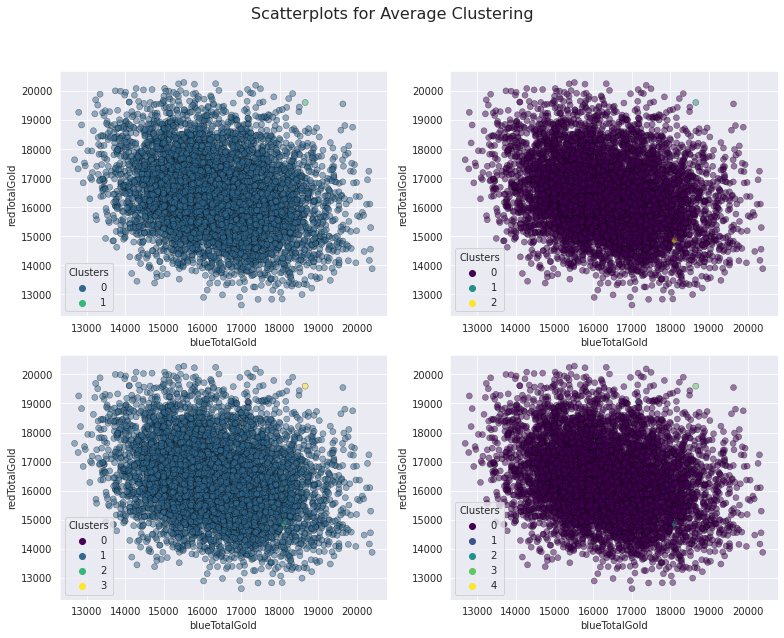

In [47]:
Average_clusters = Clusters('Average Clustering', Average_list, data_not_scaled)
Average_clusters.plot()

[back to top](#top)

<a id = 'single'></a>
### Single Clustering

In [48]:
timer = TimeIt()
Single_list = [AgglomerativeClustering(n_clusters = i, linkage = 'single').fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 4 seconds


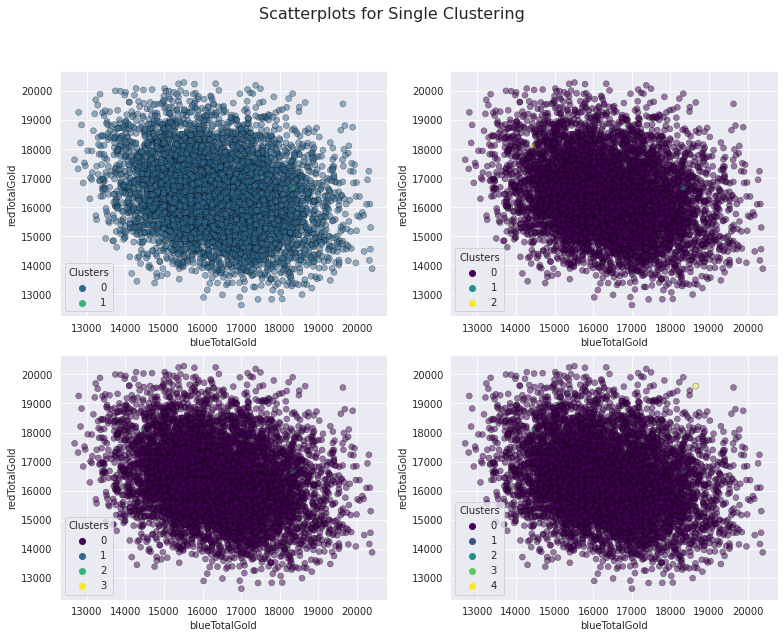

In [49]:
Single_clusters = Clusters('Single Clustering', Single_list, data_not_scaled)
Single_clusters.plot()

[back to top](#top)

<a id = 'dbscan'></a>
## DBSCAN
According to the sklearn documentation: "The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster."

In [50]:
from sklearn.cluster import DBSCAN

timer = TimeIt()
DB_list = [DBSCAN(eps = 2 + 0.25*i).fit(data_copy.values) for i in range(1,5)]
timer.stop()

Time elapsed is 2 seconds


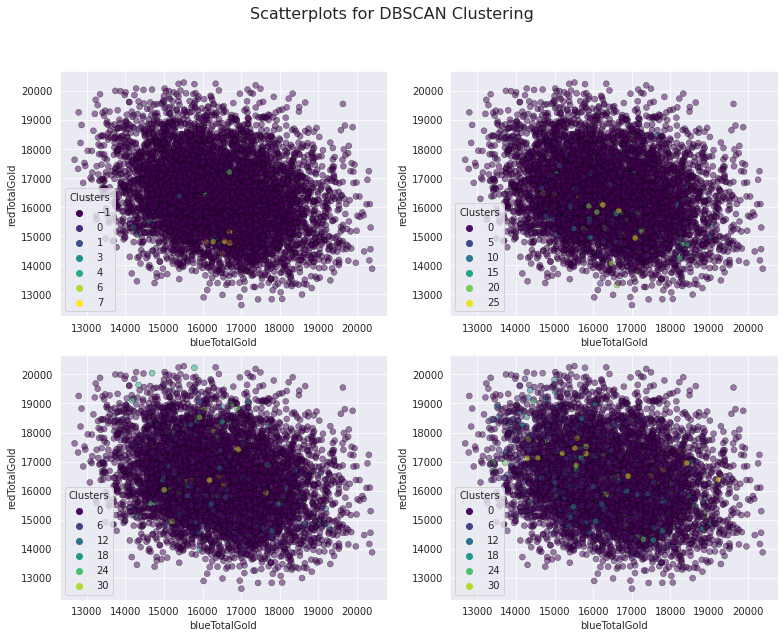

In [51]:
DB_clusters = Clusters('DBSCAN Clustering', DB_list, data_not_scaled)
DB_clusters.plot()

[back to top](#top)

<a id = 'optics'></a>
## OPTICS

According to the sklearn documentation: "The OPTICS algorithm shares many similarities with the DBSCAN algorithm, and can be considered a generalization of DBSCAN that relaxes the eps requirement from a single value to a value range. The key difference between DBSCAN and OPTICS is that the OPTICS algorithm builds a reachability graph, which assigns each sample both a reachability_ distance, and a spot within the cluster ordering_ attribute; these two attributes are assigned when the model is fitted, and are used to determine cluster membership. If OPTICS is run with the default value of inf set for max_eps, then DBSCAN style cluster extraction can be performed repeatedly in linear time for any given eps value using the cluster_optics_dbscan method. Setting max_eps to a lower value will result in shorter run times, and can be thought of as the maximum neighborhood radius from each point to find other potential reachable points."

In [52]:
from sklearn.cluster import OPTICS

timer = TimeIt()
opt_list = [OPTICS(min_samples = i).fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 2 minutes 29 seconds


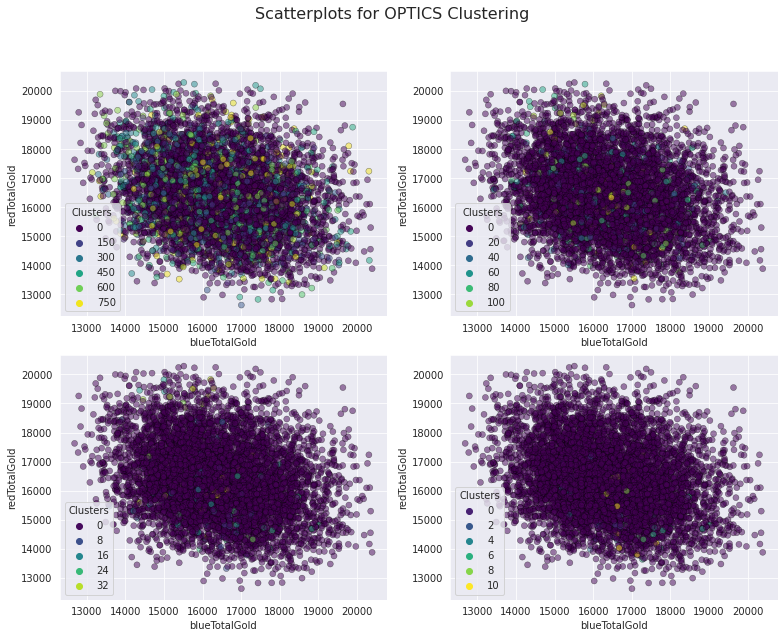

In [53]:
opt_clusters = Clusters('OPTICS Clustering', opt_list, data_not_scaled)
opt_clusters.plot()

[back to top](#top)

<a id = 'birch'></a>
## Birch

According to the sklearn documentation: "The Birch builds a tree called the Clustering Feature Tree (CFT) for the given data. The data is essentially lossy compressed to a set of Clustering Feature nodes (CF Nodes). The CF Nodes have a number of subclusters called Clustering Feature subclusters (CF Subclusters) and these CF Subclusters located in the non-terminal CF Nodes can have CF Nodes as children."

In [54]:
from sklearn.cluster import Birch

timer = TimeIt()
birch_list = [Birch(n_clusters = i).fit(data_copy.values) for i in range(2,6)]
timer.stop()

Time elapsed is 15 seconds


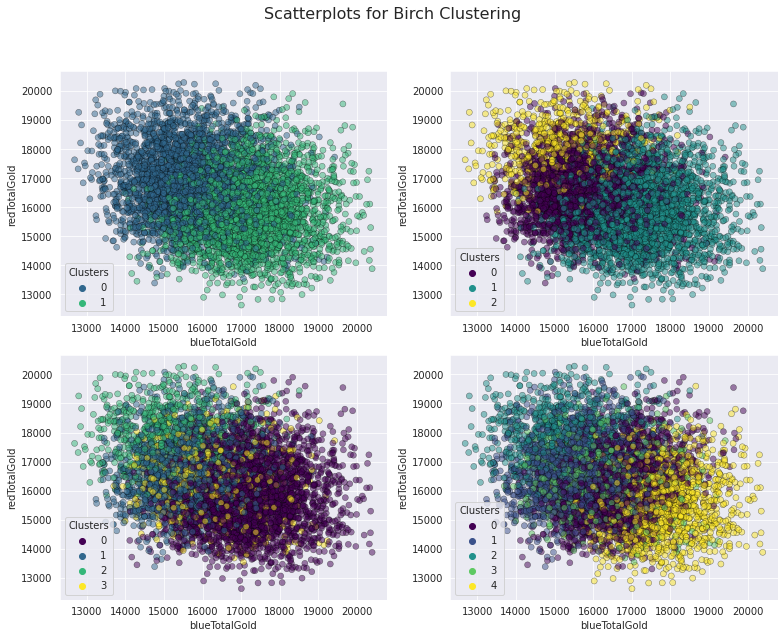

In [55]:
birch_clusters = Clusters('Birch Clustering', birch_list, data_not_scaled)
birch_clusters.plot()

[back to top](#top)

<a id = 'discussion'></a>
## Clustering Discussion

Of all of the clustering algorithms that we saw, the one that clustered the games best was the K-Means Clustering algorithm. This algorithm converged to a solution for all four cases in 6 seconds, which was much faster than the other clustering algorithms.

If we take a closer look at the documentation, we can see that SKlean mentions that the algorithm works best when we suspect that there are a small amount of clusters.

[back to top](#top)

<a id = 'advantage'></a>
## Team Advantage Analysis

Before we end this notebook, I wanted to spend time to create a column for which team has the advantage. I will define advantage as the team that has the higher combined stats after the first 10 minutes into the game. For example: we will say that blue team has the advantage in a game if they have more kills, less deaths, more gold, more experience, etc.

We begin by defining a column for the team's vision score. In the game, vision is controlled by placing vision wards that allow the team to see an area on the map that was previously hidden. The enemy team can destroy wards and deny visibility to some areas on the map. Having better vision of the map gives the team an advantage, so I think it is necessary to define this column.

In [56]:
data_not_scaled['blueVisionScore'] = data_not_scaled['blueWardsPlaced'] + data_not_scaled['redWardsDestroyed']
data_not_scaled['redVisionScore'] = data_not_scaled['redWardsPlaced'] + data_not_scaled['blueWardsDestroyed']
# make sure tha columns were added
data_not_scaled.columns

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
       'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds',
       'redTowersDestroyed', 'redTotalGold', 'redAvgLevel',
       'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redCSPerMin', 'redGoldPerMin',
       'blueWins', 'blueVisionScore', 'redVisionScore'],
      dtype='object')

To create the advantage column, we should compare (blue kills and red kills), 
(blue assists and red assists), (blue elite monsters and red elite monsters), 
(blue dragons and red dragons), (blue heralds and red heralds),
(blue towers destroyed and red towers destroyed),
(blue avg level and red avg level),
(blue total minions killed and red total minions killed), (blue jungle minions killed and red jungle minions killed),
(gold difference), (experience difference), (blue cs per min and red cs per min), (blue gold per min and red gold per min),
and (vision score)

In [57]:
"""
I am hiding this cell and the following cell because they don't look clean.
If anyone has an idea of how to produce these columns in a better way,
please let me know!
"""
# first we define a column that contains points for how advantaged the team is
timer = TimeIt()
data_not_scaled['blueAdvantagePoints'] = [0]*data_not_scaled.shape[0]
for ind in range(data_not_scaled.shape[0]):
    data_not_scaled.loc[ind ,'blueAdvantagePoints'] = int(data_not_scaled['blueKills'].iloc[ind] > data_not_scaled['blueDeaths'].iloc[ind]) + int(data_not_scaled['blueAssists'].iloc[ind] > data_not_scaled['redAssists'].iloc[ind]) + int(data_not_scaled['blueEliteMonsters'].iloc[ind] > data_not_scaled['redEliteMonsters'].iloc[ind]) + int(data_not_scaled['blueDragons'].iloc[ind] > data_not_scaled['redDragons'].iloc[ind]) + int(data_not_scaled['blueHeralds'].iloc[ind] > data_not_scaled['redHeralds'].iloc[ind]) + int(data_not_scaled['redTowersDestroyed'].iloc[ind] > data_not_scaled['blueTowersDestroyed'].iloc[ind]) + int(data_not_scaled['blueAvgLevel'].iloc[ind] > data_not_scaled['redAvgLevel'].iloc[ind]) + int(data_not_scaled['blueTotalMinionsKilled'].iloc[ind] > data_not_scaled['redTotalMinionsKilled'].iloc[ind]) + int(data_not_scaled['blueTotalJungleMinionsKilled'].iloc[ind] > data_not_scaled['redTotalJungleMinionsKilled'].iloc[ind]) + int(data_not_scaled['blueGoldDiff'].iloc[ind] > 0) + int(data_not_scaled['blueExperienceDiff'].iloc[ind] > 0) + int(data_not_scaled['blueCSPerMin'].iloc[ind] > data_not_scaled['redCSPerMin'].iloc[ind]) + int(data_not_scaled['blueGoldPerMin'].iloc[ind] > data_not_scaled['redGoldPerMin'].iloc[ind]) + int(data_not_scaled['blueVisionScore'].iloc[ind] > data_not_scaled['redVisionScore'].iloc[ind])
timer.stop()

Time elapsed is 9 seconds


In [58]:
# now the red team
timer = TimeIt()
data_not_scaled['redAdvantagePoints'] = [0]*data_not_scaled.shape[0]
for ind in range(data_not_scaled.shape[0]):
    data_not_scaled.loc[ind ,'redAdvantagePoints'] = int(data_not_scaled['blueKills'].iloc[ind] < data_not_scaled['blueDeaths'].iloc[ind]) + int(data_not_scaled['blueAssists'].iloc[ind] < data_not_scaled['redAssists'].iloc[ind]) + int(data_not_scaled['blueEliteMonsters'].iloc[ind] < data_not_scaled['redEliteMonsters'].iloc[ind]) + int(data_not_scaled['blueDragons'].iloc[ind] < data_not_scaled['redDragons'].iloc[ind]) + int(data_not_scaled['blueHeralds'].iloc[ind] < data_not_scaled['redHeralds'].iloc[ind]) + int(data_not_scaled['redTowersDestroyed'].iloc[ind] < data_not_scaled['blueTowersDestroyed'].iloc[ind]) + int(data_not_scaled['blueAvgLevel'].iloc[ind] < data_not_scaled['redAvgLevel'].iloc[ind]) + int(data_not_scaled['blueTotalMinionsKilled'].iloc[ind] < data_not_scaled['redTotalMinionsKilled'].iloc[ind]) + int(data_not_scaled['blueTotalJungleMinionsKilled'].iloc[ind] < data_not_scaled['redTotalJungleMinionsKilled'].iloc[ind]) + int(data_not_scaled['blueGoldDiff'].iloc[ind] < 0) + int(data_not_scaled['blueExperienceDiff'].iloc[ind] < 0) + int(data_not_scaled['blueCSPerMin'].iloc[ind] < data_not_scaled['redCSPerMin'].iloc[ind]) + int(data_not_scaled['blueGoldPerMin'].iloc[ind] < data_not_scaled['redGoldPerMin'].iloc[ind]) + int(data_not_scaled['blueVisionScore'].iloc[ind] < data_not_scaled['redVisionScore'].iloc[ind])
timer.stop()

Time elapsed is 9 seconds


In [59]:
# let's look at the columns we just created
data_not_scaled.loc[:5, ('blueAdvantagePoints', 'redAdvantagePoints')]

blueAdvantagePoints  redAdvantagePoints
0                    5                   5
1                    4                   7
2                    2                   8
3                    9                   2
4                   10                   2
5                    2                  10

In [60]:
# finally, we make a column defining whether blue team has the advantage or not.
timer = TimeIt()
data_not_scaled['blueAdvantage'] = [np.nan]*data_not_scaled.shape[0]
for ind in range(data_not_scaled.shape[0]):
    if data_not_scaled.loc[ind, 'blueAdvantagePoints'] > data_not_scaled.loc[ind, 'redAdvantagePoints']:
        data_not_scaled.loc[ind, 'blueAdvantage'] = 1
    elif data_not_scaled.loc[ind, 'blueAdvantagePoints'] < data_not_scaled.loc[ind, 'redAdvantagePoints']:
        data_not_scaled.loc[ind, 'blueAdvantage'] = 0
    else:
        data_not_scaled.loc[ind, 'blueAdvantage'] = np.nan
timer.stop()

Time elapsed is 2 seconds


In [61]:
data_not_scaled.loc[:5, ('blueAdvantagePoints', 'redAdvantagePoints', 'blueAdvantage')]

blueAdvantagePoints  redAdvantagePoints  blueAdvantage
0                    5                   5            NaN
1                    4                   7            0.0
2                    2                   8            0.0
3                    9                   2            1.0
4                   10                   2            1.0
5                    2                  10            0.0

Now that we have the advantage column defined, we can see what percent of games blue team lost when they had the advantage.

In [62]:
# I suspect it is around 20-25%
blue_loss_with_advantage = data_not_scaled[(data_not_scaled['blueWins'] == 0) & (data_not_scaled['blueAdvantage'] == 1)].shape[0]/data_not_scaled.shape[0]
red_loss_with_advantage = data_not_scaled[(data_not_scaled['blueWins'] == 1) & (data_not_scaled['blueAdvantage'] == 0)].shape[0]/data_not_scaled.shape[0]

print('Percent of games where blue lost with the advantage: {:.2f}%\n'.format(blue_loss_with_advantage*100))
print('Percent of games where red lost with the advantage: {:.2f}%'.format(red_loss_with_advantage*100))

Percent of games where blue lost with the advantage: 18.64%

Percent of games where red lost with the advantage: 19.68%


[back to top](#top)